In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

C:\Users\stephen.aylward\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
img_dir = "../../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding-Annotations-Linear/"

all_images = sorted(glob(os.path.join(img_dir, '*_?????.mha')))
all_labels = sorted(glob(os.path.join(img_dir, '*.interpolated-overlay.mha')))

num_images = len(all_images)
num_labels = len(all_labels)
print(num_images, num_labels)

val_images = []
val_labels = []
train_images = []
train_labels = []
for i in range(num_images):
    if i%8 == 0:
        val_images.append(all_images[i])
        val_labels.append(all_labels[i])
    else:
        train_images.append(all_images[i])
        train_labels.append(all_labels[i])

print(len(train_images), len(val_images))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

58 58
50 8


In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


torch.Size([1, 1, 320, 320, 48])
torch.Size([320, 320, 48])
image shape: torch.Size([320, 320, 48]), label shape: torch.Size([320, 320, 48])


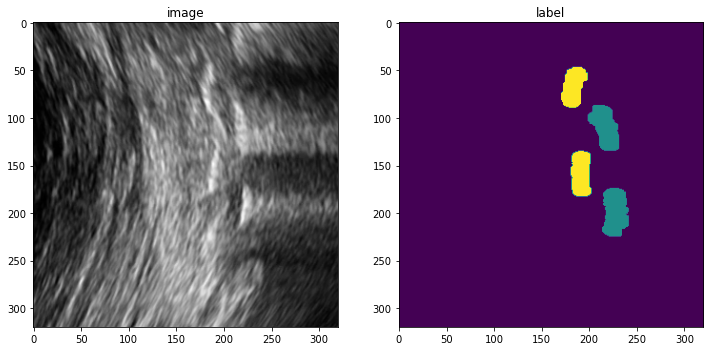

In [4]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()

In [5]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=0.25, num_workers=0)
#train_ds = Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)


val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=0.25, num_workers=0)
#val_ds = Dataset(data=val_files, transform=val_transforms)
    
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

Loading dataset: 100%|███████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [8]:
max_epochs = 2000
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=4)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=4)])

root_dir = "."

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (320, 320, 48)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "BAMC_PTX_3DUNet-4Class.best_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/2000
1/6, train_loss: 0.8508
2/6, train_loss: 0.8472
3/6, train_loss: 0.8482
4/6, train_loss: 0.8428
5/6, train_loss: 0.8409
6/6, train_loss: 0.8419
7/6, train_loss: 0.8414
epoch 1 average loss: 0.8447
----------
epoch 2/2000
1/6, train_loss: 0.8414
2/6, train_loss: 0.8385
3/6, train_loss: 0.8359
4/6, train_loss: 0.8382
5/6, train_loss: 0.8314
6/6, train_loss: 0.8321
7/6, train_loss: 0.8320
epoch 2 average loss: 0.8356
saved new best metric model
current epoch: 2 current mean dice: 0.0549
best mean dice: 0.0549 at epoch: 2
----------
epoch 3/2000
1/6, train_loss: 0.8303
2/6, train_loss: 0.8315
3/6, train_loss: 0.8306
4/6, train_loss: 0.8279
5/6, train_loss: 0.8216
6/6, train_loss: 0.8277
7/6, train_loss: 0.8396
epoch 3 average loss: 0.8299
----------
epoch 4/2000
1/6, train_loss: 0.8302
2/6, train_loss: 0.8188
3/6, train_loss: 0.8270
4/6, train_loss: 0.8212
5/6, train_loss: 0.8201
6/6, train_loss: 0.8209
7/6, train_loss: 0.8318
epoch 4 average loss: 0.8243
saved new 

4/6, train_loss: 0.6899
5/6, train_loss: 0.6782
6/6, train_loss: 0.6220
7/6, train_loss: 0.6557
epoch 31 average loss: 0.6682
----------
epoch 32/2000
1/6, train_loss: 0.6527
2/6, train_loss: 0.6771
3/6, train_loss: 0.6451
4/6, train_loss: 0.6846
5/6, train_loss: 0.6581
6/6, train_loss: 0.6628
7/6, train_loss: 0.7135
epoch 32 average loss: 0.6706
current epoch: 32 current mean dice: 0.2247
best mean dice: 0.2935 at epoch: 22
----------
epoch 33/2000
1/6, train_loss: 0.6571
2/6, train_loss: 0.6379
3/6, train_loss: 0.6667
4/6, train_loss: 0.6711
5/6, train_loss: 0.6746
6/6, train_loss: 0.6671
7/6, train_loss: 0.6650
epoch 33 average loss: 0.6628
----------
epoch 34/2000
1/6, train_loss: 0.6689
2/6, train_loss: 0.6548
3/6, train_loss: 0.6424
4/6, train_loss: 0.6904
5/6, train_loss: 0.6591
6/6, train_loss: 0.6824
7/6, train_loss: 0.6453
epoch 34 average loss: 0.6633
saved new best metric model
current epoch: 34 current mean dice: 0.3304
best mean dice: 0.3304 at epoch: 34
----------
epoch 

1/6, train_loss: 0.5512
2/6, train_loss: 0.5256
3/6, train_loss: 0.5389
4/6, train_loss: 0.4889
5/6, train_loss: 0.5666
6/6, train_loss: 0.5109
7/6, train_loss: 0.6355
epoch 62 average loss: 0.5454
saved new best metric model
current epoch: 62 current mean dice: 0.4857
best mean dice: 0.4857 at epoch: 62
----------
epoch 63/2000
1/6, train_loss: 0.5824
2/6, train_loss: 0.5275
3/6, train_loss: 0.5440
4/6, train_loss: 0.5196
5/6, train_loss: 0.4993
6/6, train_loss: 0.5255
7/6, train_loss: 0.5540
epoch 63 average loss: 0.5360
----------
epoch 64/2000
1/6, train_loss: 0.5112
2/6, train_loss: 0.5281
3/6, train_loss: 0.5422
4/6, train_loss: 0.5348
5/6, train_loss: 0.5497
6/6, train_loss: 0.5343
7/6, train_loss: 0.4985
epoch 64 average loss: 0.5284
current epoch: 64 current mean dice: 0.3919
best mean dice: 0.4857 at epoch: 62
----------
epoch 65/2000
1/6, train_loss: 0.5096
2/6, train_loss: 0.5459
3/6, train_loss: 0.5185
4/6, train_loss: 0.5586
5/6, train_loss: 0.5370
6/6, train_loss: 0.5305

current epoch: 92 current mean dice: 0.4828
best mean dice: 0.5163 at epoch: 74
----------
epoch 93/2000
1/6, train_loss: 0.4870
2/6, train_loss: 0.4364
3/6, train_loss: 0.4531
4/6, train_loss: 0.4461
5/6, train_loss: 0.4633
6/6, train_loss: 0.4442
7/6, train_loss: 0.5373
epoch 93 average loss: 0.4668
----------
epoch 94/2000
1/6, train_loss: 0.4882
2/6, train_loss: 0.4571
3/6, train_loss: 0.4718
4/6, train_loss: 0.4807
5/6, train_loss: 0.4586
6/6, train_loss: 0.4761
7/6, train_loss: 0.4197
epoch 94 average loss: 0.4646
saved new best metric model
current epoch: 94 current mean dice: 0.5773
best mean dice: 0.5773 at epoch: 94
----------
epoch 95/2000
1/6, train_loss: 0.4277
2/6, train_loss: 0.4427
3/6, train_loss: 0.4699
4/6, train_loss: 0.4521
5/6, train_loss: 0.4788
6/6, train_loss: 0.4922
7/6, train_loss: 0.4483
epoch 95 average loss: 0.4588
----------
epoch 96/2000
1/6, train_loss: 0.4425
2/6, train_loss: 0.4414
3/6, train_loss: 0.4532
4/6, train_loss: 0.4517
5/6, train_loss: 0.476

5/6, train_loss: 0.4280
6/6, train_loss: 0.4131
7/6, train_loss: 0.4370
epoch 123 average loss: 0.4367
----------
epoch 124/2000
1/6, train_loss: 0.4598
2/6, train_loss: 0.4343
3/6, train_loss: 0.4397
4/6, train_loss: 0.4007
5/6, train_loss: 0.4291
6/6, train_loss: 0.4226
7/6, train_loss: 0.4202
epoch 124 average loss: 0.4295
current epoch: 124 current mean dice: 0.4771
best mean dice: 0.5896 at epoch: 116
----------
epoch 125/2000
1/6, train_loss: 0.4257
2/6, train_loss: 0.4202
3/6, train_loss: 0.4320
4/6, train_loss: 0.4576
5/6, train_loss: 0.4195
6/6, train_loss: 0.4301
7/6, train_loss: 0.5014
epoch 125 average loss: 0.4409
----------
epoch 126/2000
1/6, train_loss: 0.4521
2/6, train_loss: 0.4417
3/6, train_loss: 0.4176
4/6, train_loss: 0.4182
5/6, train_loss: 0.4132
6/6, train_loss: 0.4275
7/6, train_loss: 0.4434
epoch 126 average loss: 0.4305
current epoch: 126 current mean dice: 0.4649
best mean dice: 0.5896 at epoch: 116
----------
epoch 127/2000
1/6, train_loss: 0.4246
2/6, tra

3/6, train_loss: 0.3886
4/6, train_loss: 0.4297
5/6, train_loss: 0.4107
6/6, train_loss: 0.4053
7/6, train_loss: 0.3886
epoch 154 average loss: 0.4068
current epoch: 154 current mean dice: 0.5735
best mean dice: 0.6264 at epoch: 150
----------
epoch 155/2000
1/6, train_loss: 0.4091
2/6, train_loss: 0.3932
3/6, train_loss: 0.3952
4/6, train_loss: 0.4104
5/6, train_loss: 0.4095
6/6, train_loss: 0.4101
7/6, train_loss: 0.4572
epoch 155 average loss: 0.4121
----------
epoch 156/2000
1/6, train_loss: 0.4005
2/6, train_loss: 0.4210
3/6, train_loss: 0.3987
4/6, train_loss: 0.4266
5/6, train_loss: 0.3929
6/6, train_loss: 0.4095
7/6, train_loss: 0.4647
epoch 156 average loss: 0.4163
current epoch: 156 current mean dice: 0.5276
best mean dice: 0.6264 at epoch: 150
----------
epoch 157/2000
1/6, train_loss: 0.4104
2/6, train_loss: 0.4079
3/6, train_loss: 0.4197
4/6, train_loss: 0.4222
5/6, train_loss: 0.4043
6/6, train_loss: 0.3930
7/6, train_loss: 0.4188
epoch 157 average loss: 0.4109
----------

1/6, train_loss: 0.4069
2/6, train_loss: 0.3671
3/6, train_loss: 0.3972
4/6, train_loss: 0.4328
5/6, train_loss: 0.4105
6/6, train_loss: 0.3903
7/6, train_loss: 0.4055
epoch 185 average loss: 0.4015
----------
epoch 186/2000
1/6, train_loss: 0.3806
2/6, train_loss: 0.3935
3/6, train_loss: 0.3940
4/6, train_loss: 0.4157
5/6, train_loss: 0.4208
6/6, train_loss: 0.4052
7/6, train_loss: 0.3893
epoch 186 average loss: 0.3999
current epoch: 186 current mean dice: 0.5828
best mean dice: 0.6264 at epoch: 150
----------
epoch 187/2000
1/6, train_loss: 0.4004
2/6, train_loss: 0.3814
3/6, train_loss: 0.4054
4/6, train_loss: 0.4154
5/6, train_loss: 0.3988
6/6, train_loss: 0.3893
7/6, train_loss: 0.3943
epoch 187 average loss: 0.3979
----------
epoch 188/2000
1/6, train_loss: 0.4032
2/6, train_loss: 0.3930
3/6, train_loss: 0.3814
4/6, train_loss: 0.4106
5/6, train_loss: 0.4147
6/6, train_loss: 0.3876
7/6, train_loss: 0.3779
epoch 188 average loss: 0.3955
current epoch: 188 current mean dice: 0.6030

1/6, train_loss: 0.3708
2/6, train_loss: 0.3735
3/6, train_loss: 0.3738
4/6, train_loss: 0.3731
5/6, train_loss: 0.3996
6/6, train_loss: 0.3853
7/6, train_loss: 0.4005
epoch 216 average loss: 0.3824
current epoch: 216 current mean dice: 0.6089
best mean dice: 0.6264 at epoch: 150
----------
epoch 217/2000
1/6, train_loss: 0.3789
2/6, train_loss: 0.3832
3/6, train_loss: 0.3840
4/6, train_loss: 0.3872
5/6, train_loss: 0.3723
6/6, train_loss: 0.3793
7/6, train_loss: 0.3493
epoch 217 average loss: 0.3763
----------
epoch 218/2000
1/6, train_loss: 0.3732
2/6, train_loss: 0.3789
3/6, train_loss: 0.3857
4/6, train_loss: 0.3760
5/6, train_loss: 0.3738
6/6, train_loss: 0.3874
7/6, train_loss: 0.3657
epoch 218 average loss: 0.3772
current epoch: 218 current mean dice: 0.5828
best mean dice: 0.6264 at epoch: 150
----------
epoch 219/2000
1/6, train_loss: 0.3730
2/6, train_loss: 0.3759
3/6, train_loss: 0.3689
4/6, train_loss: 0.3895
5/6, train_loss: 0.3848
6/6, train_loss: 0.3812
7/6, train_loss: 

1/6, train_loss: 0.3710
2/6, train_loss: 0.4168
3/6, train_loss: 0.3900
4/6, train_loss: 0.3779
5/6, train_loss: 0.3785
6/6, train_loss: 0.3828
7/6, train_loss: 0.3779
epoch 247 average loss: 0.3850
----------
epoch 248/2000
1/6, train_loss: 0.4014
2/6, train_loss: 0.3636
3/6, train_loss: 0.3797
4/6, train_loss: 0.3710
5/6, train_loss: 0.3833
6/6, train_loss: 0.3777
7/6, train_loss: 0.3816
epoch 248 average loss: 0.3798
current epoch: 248 current mean dice: 0.5775
best mean dice: 0.6264 at epoch: 150
----------
epoch 249/2000
1/6, train_loss: 0.3899
2/6, train_loss: 0.3635
3/6, train_loss: 0.3907
4/6, train_loss: 0.3766
5/6, train_loss: 0.3706
6/6, train_loss: 0.3803
7/6, train_loss: 0.3929
epoch 249 average loss: 0.3806
----------
epoch 250/2000
1/6, train_loss: 0.3586
2/6, train_loss: 0.3697
3/6, train_loss: 0.3755
4/6, train_loss: 0.3897
5/6, train_loss: 0.4002
6/6, train_loss: 0.3830
7/6, train_loss: 0.3698
epoch 250 average loss: 0.3781
current epoch: 250 current mean dice: 0.5754

1/6, train_loss: 0.3713
2/6, train_loss: 0.3805
3/6, train_loss: 0.3799
4/6, train_loss: 0.3694
5/6, train_loss: 0.3599
6/6, train_loss: 0.3599
7/6, train_loss: 0.3874
epoch 278 average loss: 0.3726
current epoch: 278 current mean dice: 0.5948
best mean dice: 0.6308 at epoch: 268
----------
epoch 279/2000
1/6, train_loss: 0.3531
2/6, train_loss: 0.3635
3/6, train_loss: 0.3682
4/6, train_loss: 0.3746
5/6, train_loss: 0.3746
6/6, train_loss: 0.3715
7/6, train_loss: 0.3653
epoch 279 average loss: 0.3672
----------
epoch 280/2000
1/6, train_loss: 0.3649
2/6, train_loss: 0.3698
3/6, train_loss: 0.3811
4/6, train_loss: 0.3642
5/6, train_loss: 0.3835
6/6, train_loss: 0.3823
7/6, train_loss: 0.3729
epoch 280 average loss: 0.3741
current epoch: 280 current mean dice: 0.6191
best mean dice: 0.6308 at epoch: 268
----------
epoch 281/2000
1/6, train_loss: 0.3654
2/6, train_loss: 0.3556
3/6, train_loss: 0.3715
4/6, train_loss: 0.3666
5/6, train_loss: 0.3688
6/6, train_loss: 0.3679
7/6, train_loss: 

1/6, train_loss: 0.3829
2/6, train_loss: 0.3593
3/6, train_loss: 0.3512
4/6, train_loss: 0.3655
5/6, train_loss: 0.3651
6/6, train_loss: 0.3604
7/6, train_loss: 0.3524
epoch 309 average loss: 0.3624
----------
epoch 310/2000
1/6, train_loss: 0.3531
2/6, train_loss: 0.3551
3/6, train_loss: 0.3679
4/6, train_loss: 0.3673
5/6, train_loss: 0.3719
6/6, train_loss: 0.3597
7/6, train_loss: 0.3885
epoch 310 average loss: 0.3662
current epoch: 310 current mean dice: 0.5943
best mean dice: 0.6308 at epoch: 268
----------
epoch 311/2000
1/6, train_loss: 0.3661
2/6, train_loss: 0.3500
3/6, train_loss: 0.3628
4/6, train_loss: 0.3717
5/6, train_loss: 0.3606
6/6, train_loss: 0.3692
7/6, train_loss: 0.4067
epoch 311 average loss: 0.3696
----------
epoch 312/2000
1/6, train_loss: 0.3643
2/6, train_loss: 0.3632
3/6, train_loss: 0.3827
4/6, train_loss: 0.3714
5/6, train_loss: 0.3675
6/6, train_loss: 0.3491
7/6, train_loss: 0.3544
epoch 312 average loss: 0.3647
current epoch: 312 current mean dice: 0.5992

1/6, train_loss: 0.3703
2/6, train_loss: 0.3678
3/6, train_loss: 0.3660
4/6, train_loss: 0.3934
5/6, train_loss: 0.3564
6/6, train_loss: 0.3790
7/6, train_loss: 0.3870
epoch 340 average loss: 0.3743
current epoch: 340 current mean dice: 0.4889
best mean dice: 0.6308 at epoch: 268
----------
epoch 341/2000
1/6, train_loss: 0.3562
2/6, train_loss: 0.3540
3/6, train_loss: 0.3779
4/6, train_loss: 0.3923
5/6, train_loss: 0.3825
6/6, train_loss: 0.3804
7/6, train_loss: 0.3795
epoch 341 average loss: 0.3747
----------
epoch 342/2000
1/6, train_loss: 0.3633
2/6, train_loss: 0.3664
3/6, train_loss: 0.3743
4/6, train_loss: 0.3813
5/6, train_loss: 0.3542
6/6, train_loss: 0.3558
7/6, train_loss: 0.3590
epoch 342 average loss: 0.3649
current epoch: 342 current mean dice: 0.3986
best mean dice: 0.6308 at epoch: 268
----------
epoch 343/2000
1/6, train_loss: 0.3621
2/6, train_loss: 0.3632
3/6, train_loss: 0.3599
4/6, train_loss: 0.3626
5/6, train_loss: 0.3664
6/6, train_loss: 0.3712
7/6, train_loss: 

1/6, train_loss: 0.3519
2/6, train_loss: 0.3626
3/6, train_loss: 0.3537
4/6, train_loss: 0.3568
5/6, train_loss: 0.3613
6/6, train_loss: 0.3519
7/6, train_loss: 0.3492
epoch 371 average loss: 0.3553
----------
epoch 372/2000
1/6, train_loss: 0.3534
2/6, train_loss: 0.3466
3/6, train_loss: 0.3584
4/6, train_loss: 0.3498
5/6, train_loss: 0.3692
6/6, train_loss: 0.3572
7/6, train_loss: 0.3873
epoch 372 average loss: 0.3602
current epoch: 372 current mean dice: 0.5635
best mean dice: 0.6308 at epoch: 268
----------
epoch 373/2000
1/6, train_loss: 0.3500
2/6, train_loss: 0.3454
3/6, train_loss: 0.3541
4/6, train_loss: 0.3764
5/6, train_loss: 0.3490
6/6, train_loss: 0.3648
7/6, train_loss: 0.3789
epoch 373 average loss: 0.3598
----------
epoch 374/2000
1/6, train_loss: 0.3530
2/6, train_loss: 0.3600
3/6, train_loss: 0.3596
4/6, train_loss: 0.3561
5/6, train_loss: 0.3481
6/6, train_loss: 0.3631
7/6, train_loss: 0.3559
epoch 374 average loss: 0.3565
current epoch: 374 current mean dice: 0.5529

1/6, train_loss: 0.3424
2/6, train_loss: 0.3589
3/6, train_loss: 0.3609
4/6, train_loss: 0.3573
5/6, train_loss: 0.3579
6/6, train_loss: 0.3655
7/6, train_loss: 0.4318
epoch 402 average loss: 0.3678
current epoch: 402 current mean dice: 0.5933
best mean dice: 0.6308 at epoch: 268
----------
epoch 403/2000
1/6, train_loss: 0.3569
2/6, train_loss: 0.3407
3/6, train_loss: 0.3628
4/6, train_loss: 0.3640
5/6, train_loss: 0.3471
6/6, train_loss: 0.3743
7/6, train_loss: 0.3783
epoch 403 average loss: 0.3606
----------
epoch 404/2000
1/6, train_loss: 0.3562
2/6, train_loss: 0.3575
3/6, train_loss: 0.3775
4/6, train_loss: 0.3788
5/6, train_loss: 0.3758
6/6, train_loss: 0.3809
7/6, train_loss: 0.3617
epoch 404 average loss: 0.3698
current epoch: 404 current mean dice: 0.5490
best mean dice: 0.6308 at epoch: 268
----------
epoch 405/2000
1/6, train_loss: 0.3581
2/6, train_loss: 0.3524
3/6, train_loss: 0.3702
4/6, train_loss: 0.3645
5/6, train_loss: 0.3488
6/6, train_loss: 0.3529
7/6, train_loss: 

1/6, train_loss: 0.3446
2/6, train_loss: 0.3563
3/6, train_loss: 0.3654
4/6, train_loss: 0.3465
5/6, train_loss: 0.3443
6/6, train_loss: 0.3465
7/6, train_loss: 0.3622
epoch 433 average loss: 0.3522
----------
epoch 434/2000
1/6, train_loss: 0.3488
2/6, train_loss: 0.3607
3/6, train_loss: 0.3479
4/6, train_loss: 0.3507
5/6, train_loss: 0.3560
6/6, train_loss: 0.3595
7/6, train_loss: 0.3793
epoch 434 average loss: 0.3575
current epoch: 434 current mean dice: 0.5158
best mean dice: 0.6308 at epoch: 268
----------
epoch 435/2000
1/6, train_loss: 0.3501
2/6, train_loss: 0.3463
3/6, train_loss: 0.3472
4/6, train_loss: 0.3561
5/6, train_loss: 0.3573
6/6, train_loss: 0.3481
7/6, train_loss: 0.3800
epoch 435 average loss: 0.3550
----------
epoch 436/2000
1/6, train_loss: 0.3618
2/6, train_loss: 0.3498
3/6, train_loss: 0.3593
4/6, train_loss: 0.3713
5/6, train_loss: 0.3512
6/6, train_loss: 0.3618
7/6, train_loss: 0.3499
epoch 436 average loss: 0.3579
current epoch: 436 current mean dice: 0.5045

1/6, train_loss: 0.3588
2/6, train_loss: 0.3576
3/6, train_loss: 0.3580
4/6, train_loss: 0.3650
5/6, train_loss: 0.3520
6/6, train_loss: 0.3561
7/6, train_loss: 0.3488
epoch 464 average loss: 0.3566
current epoch: 464 current mean dice: 0.4477
best mean dice: 0.6308 at epoch: 268
----------
epoch 465/2000
1/6, train_loss: 0.3525
2/6, train_loss: 0.3494
3/6, train_loss: 0.3510
4/6, train_loss: 0.3563
5/6, train_loss: 0.3394
6/6, train_loss: 0.3550
7/6, train_loss: 0.3471
epoch 465 average loss: 0.3501
----------
epoch 466/2000
1/6, train_loss: 0.3547
2/6, train_loss: 0.3533
3/6, train_loss: 0.3591
4/6, train_loss: 0.3556
5/6, train_loss: 0.3385
6/6, train_loss: 0.3518
7/6, train_loss: 0.3364
epoch 466 average loss: 0.3499
current epoch: 466 current mean dice: 0.5384
best mean dice: 0.6308 at epoch: 268
----------
epoch 467/2000
1/6, train_loss: 0.3387
2/6, train_loss: 0.3495
3/6, train_loss: 0.3528
4/6, train_loss: 0.3507
5/6, train_loss: 0.3451
6/6, train_loss: 0.3512
7/6, train_loss: 

1/6, train_loss: 0.3450
2/6, train_loss: 0.3449
3/6, train_loss: 0.3511
4/6, train_loss: 0.3580
5/6, train_loss: 0.3510
6/6, train_loss: 0.3545
7/6, train_loss: 0.3417
epoch 495 average loss: 0.3495
----------
epoch 496/2000
1/6, train_loss: 0.3483
2/6, train_loss: 0.3458
3/6, train_loss: 0.3616
4/6, train_loss: 0.3449
5/6, train_loss: 0.3500
6/6, train_loss: 0.3405
7/6, train_loss: 0.3323
epoch 496 average loss: 0.3462
current epoch: 496 current mean dice: 0.5912
best mean dice: 0.6308 at epoch: 268
----------
epoch 497/2000
1/6, train_loss: 0.3477
2/6, train_loss: 0.3473
3/6, train_loss: 0.3524
4/6, train_loss: 0.3563
5/6, train_loss: 0.3601
6/6, train_loss: 0.3413
7/6, train_loss: 0.3313
epoch 497 average loss: 0.3480
----------
epoch 498/2000
1/6, train_loss: 0.3486
2/6, train_loss: 0.3527
3/6, train_loss: 0.3394
4/6, train_loss: 0.3532
5/6, train_loss: 0.3519
6/6, train_loss: 0.3423
7/6, train_loss: 0.3424
epoch 498 average loss: 0.3472
current epoch: 498 current mean dice: 0.5928

1/6, train_loss: 0.3380
2/6, train_loss: 0.3500
3/6, train_loss: 0.3478
4/6, train_loss: 0.3578
5/6, train_loss: 0.3462
6/6, train_loss: 0.3599
7/6, train_loss: 0.3263
epoch 526 average loss: 0.3466
current epoch: 526 current mean dice: 0.6063
best mean dice: 0.6308 at epoch: 268
----------
epoch 527/2000
1/6, train_loss: 0.3390
2/6, train_loss: 0.3439
3/6, train_loss: 0.3374
4/6, train_loss: 0.3562
5/6, train_loss: 0.3542
6/6, train_loss: 0.3466
7/6, train_loss: 0.3331
epoch 527 average loss: 0.3443
----------
epoch 528/2000
1/6, train_loss: 0.3605
2/6, train_loss: 0.3538
3/6, train_loss: 0.3391
4/6, train_loss: 0.3355
5/6, train_loss: 0.3470
6/6, train_loss: 0.3460
7/6, train_loss: 0.3410
epoch 528 average loss: 0.3461
current epoch: 528 current mean dice: 0.5956
best mean dice: 0.6308 at epoch: 268
----------
epoch 529/2000
1/6, train_loss: 0.3528
2/6, train_loss: 0.3401
3/6, train_loss: 0.3450
4/6, train_loss: 0.3477
5/6, train_loss: 0.3552
6/6, train_loss: 0.3410
7/6, train_loss: 

1/6, train_loss: 0.3440
2/6, train_loss: 0.3595
3/6, train_loss: 0.3446
4/6, train_loss: 0.3663
5/6, train_loss: 0.3473
6/6, train_loss: 0.3463
7/6, train_loss: 0.3769
epoch 557 average loss: 0.3550
----------
epoch 558/2000
1/6, train_loss: 0.3629
2/6, train_loss: 0.3442
3/6, train_loss: 0.3529
4/6, train_loss: 0.3481
5/6, train_loss: 0.3590
6/6, train_loss: 0.3463
7/6, train_loss: 0.3893
epoch 558 average loss: 0.3575
current epoch: 558 current mean dice: 0.5526
best mean dice: 0.6308 at epoch: 268
----------
epoch 559/2000
1/6, train_loss: 0.3515
2/6, train_loss: 0.3537
3/6, train_loss: 0.3484
4/6, train_loss: 0.3481
5/6, train_loss: 0.3456
6/6, train_loss: 0.3519
7/6, train_loss: 0.3511
epoch 559 average loss: 0.3501
----------
epoch 560/2000
1/6, train_loss: 0.3656
2/6, train_loss: 0.3490
3/6, train_loss: 0.3469
4/6, train_loss: 0.3489
5/6, train_loss: 0.3457
6/6, train_loss: 0.3483
7/6, train_loss: 0.3308
epoch 560 average loss: 0.3479
current epoch: 560 current mean dice: 0.6023

1/6, train_loss: 0.3457
2/6, train_loss: 0.3532
3/6, train_loss: 0.3344
4/6, train_loss: 0.3478
5/6, train_loss: 0.3364
6/6, train_loss: 0.3397
7/6, train_loss: 0.3271
epoch 588 average loss: 0.3406
current epoch: 588 current mean dice: 0.5997
best mean dice: 0.6308 at epoch: 268
----------
epoch 589/2000
1/6, train_loss: 0.3418
2/6, train_loss: 0.3364
3/6, train_loss: 0.3389
4/6, train_loss: 0.3453
5/6, train_loss: 0.3557
6/6, train_loss: 0.3416
7/6, train_loss: 0.4015
epoch 589 average loss: 0.3516
----------
epoch 590/2000
1/6, train_loss: 0.3363
2/6, train_loss: 0.3465
3/6, train_loss: 0.3557
4/6, train_loss: 0.3449
5/6, train_loss: 0.3469
6/6, train_loss: 0.3369
7/6, train_loss: 0.3493
epoch 590 average loss: 0.3452
current epoch: 590 current mean dice: 0.5278
best mean dice: 0.6308 at epoch: 268
----------
epoch 591/2000
1/6, train_loss: 0.3363
2/6, train_loss: 0.3387
3/6, train_loss: 0.3413
4/6, train_loss: 0.3307
5/6, train_loss: 0.3419
6/6, train_loss: 0.3455
7/6, train_loss: 

1/6, train_loss: 0.3374
2/6, train_loss: 0.3488
3/6, train_loss: 0.3320
4/6, train_loss: 0.3547
5/6, train_loss: 0.3383
6/6, train_loss: 0.3392
7/6, train_loss: 0.3485
epoch 619 average loss: 0.3427
----------
epoch 620/2000
1/6, train_loss: 0.3449
2/6, train_loss: 0.3398
3/6, train_loss: 0.3361
4/6, train_loss: 0.3393
5/6, train_loss: 0.3380
6/6, train_loss: 0.3488
7/6, train_loss: 0.3385
epoch 620 average loss: 0.3408
current epoch: 620 current mean dice: 0.4999
best mean dice: 0.6308 at epoch: 268
----------
epoch 621/2000
1/6, train_loss: 0.3362
2/6, train_loss: 0.3367
3/6, train_loss: 0.3338
4/6, train_loss: 0.3355
5/6, train_loss: 0.3414
6/6, train_loss: 0.3445
7/6, train_loss: 0.3615
epoch 621 average loss: 0.3414
----------
epoch 622/2000
1/6, train_loss: 0.3421
2/6, train_loss: 0.3456
3/6, train_loss: 0.3402
4/6, train_loss: 0.3312
5/6, train_loss: 0.3346
6/6, train_loss: 0.3406
7/6, train_loss: 0.3582
epoch 622 average loss: 0.3418
current epoch: 622 current mean dice: 0.5844

1/6, train_loss: 0.3446
2/6, train_loss: 0.3371
3/6, train_loss: 0.3400
4/6, train_loss: 0.3340
5/6, train_loss: 0.3330
6/6, train_loss: 0.3272
7/6, train_loss: 0.3797
epoch 650 average loss: 0.3422
current epoch: 650 current mean dice: 0.6098
best mean dice: 0.6308 at epoch: 268
----------
epoch 651/2000
1/6, train_loss: 0.3321
2/6, train_loss: 0.3418
3/6, train_loss: 0.3303
4/6, train_loss: 0.3474
5/6, train_loss: 0.3425
6/6, train_loss: 0.3362
7/6, train_loss: 0.3651
epoch 651 average loss: 0.3422
----------
epoch 652/2000
1/6, train_loss: 0.3452
2/6, train_loss: 0.3340
3/6, train_loss: 0.3480
4/6, train_loss: 0.3458
5/6, train_loss: 0.3298
6/6, train_loss: 0.3409
7/6, train_loss: 0.3317
epoch 652 average loss: 0.3393
current epoch: 652 current mean dice: 0.5810
best mean dice: 0.6308 at epoch: 268
----------
epoch 653/2000
1/6, train_loss: 0.3417
2/6, train_loss: 0.3390
3/6, train_loss: 0.3362
4/6, train_loss: 0.3397
5/6, train_loss: 0.3335
6/6, train_loss: 0.3400
7/6, train_loss: 

1/6, train_loss: 0.3372
2/6, train_loss: 0.3335
3/6, train_loss: 0.3449
4/6, train_loss: 0.3427
5/6, train_loss: 0.3350
6/6, train_loss: 0.3332
7/6, train_loss: 0.3310
epoch 681 average loss: 0.3368
----------
epoch 682/2000
1/6, train_loss: 0.3323
2/6, train_loss: 0.3365
3/6, train_loss: 0.3414
4/6, train_loss: 0.3348
5/6, train_loss: 0.3340
6/6, train_loss: 0.3341
7/6, train_loss: 0.3362
epoch 682 average loss: 0.3356
current epoch: 682 current mean dice: 0.5855
best mean dice: 0.6308 at epoch: 268
----------
epoch 683/2000
1/6, train_loss: 0.3370
2/6, train_loss: 0.3427
3/6, train_loss: 0.3367
4/6, train_loss: 0.3334
5/6, train_loss: 0.3426
6/6, train_loss: 0.3397
7/6, train_loss: 0.3148
epoch 683 average loss: 0.3353
----------
epoch 684/2000
1/6, train_loss: 0.3327
2/6, train_loss: 0.3334
3/6, train_loss: 0.3368
4/6, train_loss: 0.3516
5/6, train_loss: 0.3366
6/6, train_loss: 0.3340
7/6, train_loss: 0.3327
epoch 684 average loss: 0.3368
current epoch: 684 current mean dice: 0.5610

1/6, train_loss: 0.3355
2/6, train_loss: 0.3333
3/6, train_loss: 0.3368
4/6, train_loss: 0.3506
5/6, train_loss: 0.3417
6/6, train_loss: 0.3353
7/6, train_loss: 0.3500
epoch 712 average loss: 0.3405
current epoch: 712 current mean dice: 0.5873
best mean dice: 0.6308 at epoch: 268
----------
epoch 713/2000
1/6, train_loss: 0.3467
2/6, train_loss: 0.3509
3/6, train_loss: 0.3334
4/6, train_loss: 0.3384
5/6, train_loss: 0.3352
6/6, train_loss: 0.3420
7/6, train_loss: 0.3716
epoch 713 average loss: 0.3455
----------
epoch 714/2000
1/6, train_loss: 0.3361
2/6, train_loss: 0.3337
3/6, train_loss: 0.3531
4/6, train_loss: 0.3415
5/6, train_loss: 0.3466
6/6, train_loss: 0.3597
7/6, train_loss: 0.3448
epoch 714 average loss: 0.3451
current epoch: 714 current mean dice: 0.5635
best mean dice: 0.6308 at epoch: 268
----------
epoch 715/2000
1/6, train_loss: 0.3408
2/6, train_loss: 0.3356
3/6, train_loss: 0.3418
4/6, train_loss: 0.3573
5/6, train_loss: 0.3364
6/6, train_loss: 0.3296
7/6, train_loss: 

1/6, train_loss: 0.3361
2/6, train_loss: 0.3343
3/6, train_loss: 0.3293
4/6, train_loss: 0.3448
5/6, train_loss: 0.3328
6/6, train_loss: 0.3330
7/6, train_loss: 0.3196
epoch 743 average loss: 0.3328
----------
epoch 744/2000
1/6, train_loss: 0.3469
2/6, train_loss: 0.3304
3/6, train_loss: 0.3280
4/6, train_loss: 0.3317
5/6, train_loss: 0.3321
6/6, train_loss: 0.3348
7/6, train_loss: 0.3428
epoch 744 average loss: 0.3353
current epoch: 744 current mean dice: 0.5535
best mean dice: 0.6308 at epoch: 268
----------
epoch 745/2000
1/6, train_loss: 0.3276
2/6, train_loss: 0.3315
3/6, train_loss: 0.3335
4/6, train_loss: 0.3316
5/6, train_loss: 0.3351
6/6, train_loss: 0.3360
7/6, train_loss: 0.3305
epoch 745 average loss: 0.3323
----------
epoch 746/2000
1/6, train_loss: 0.3334
2/6, train_loss: 0.3356
3/6, train_loss: 0.3361
4/6, train_loss: 0.3372
5/6, train_loss: 0.3298
6/6, train_loss: 0.3364
7/6, train_loss: 0.3393
epoch 746 average loss: 0.3354
current epoch: 746 current mean dice: 0.5909

1/6, train_loss: 0.3381
2/6, train_loss: 0.3452
3/6, train_loss: 0.3440
4/6, train_loss: 0.3388
5/6, train_loss: 0.3393
6/6, train_loss: 0.3301
7/6, train_loss: 0.3357
epoch 774 average loss: 0.3387
current epoch: 774 current mean dice: 0.5611
best mean dice: 0.6308 at epoch: 268
----------
epoch 775/2000
1/6, train_loss: 0.3421
2/6, train_loss: 0.3229
3/6, train_loss: 0.3404
4/6, train_loss: 0.3455
5/6, train_loss: 0.3428
6/6, train_loss: 0.3362
7/6, train_loss: 0.3237
epoch 775 average loss: 0.3362
----------
epoch 776/2000
1/6, train_loss: 0.3342
2/6, train_loss: 0.3335
3/6, train_loss: 0.3311
4/6, train_loss: 0.3402
5/6, train_loss: 0.3356
6/6, train_loss: 0.3313
7/6, train_loss: 0.3358
epoch 776 average loss: 0.3345
current epoch: 776 current mean dice: 0.5631
best mean dice: 0.6308 at epoch: 268
----------
epoch 777/2000
1/6, train_loss: 0.3233
2/6, train_loss: 0.3411
3/6, train_loss: 0.3382
4/6, train_loss: 0.3391
5/6, train_loss: 0.3282
6/6, train_loss: 0.3389
7/6, train_loss: 

1/6, train_loss: 0.3244
2/6, train_loss: 0.3455
3/6, train_loss: 0.3345
4/6, train_loss: 0.3313
5/6, train_loss: 0.3344
6/6, train_loss: 0.3313
7/6, train_loss: 0.3201
epoch 805 average loss: 0.3317
----------
epoch 806/2000
1/6, train_loss: 0.3342
2/6, train_loss: 0.3269
3/6, train_loss: 0.3281
4/6, train_loss: 0.3366
5/6, train_loss: 0.3259
6/6, train_loss: 0.3298
7/6, train_loss: 0.3256
epoch 806 average loss: 0.3296
current epoch: 806 current mean dice: 0.5767
best mean dice: 0.6308 at epoch: 268
----------
epoch 807/2000
1/6, train_loss: 0.3385
2/6, train_loss: 0.3311
3/6, train_loss: 0.3308
4/6, train_loss: 0.3268
5/6, train_loss: 0.3375
6/6, train_loss: 0.3328
7/6, train_loss: 0.3428
epoch 807 average loss: 0.3343
----------
epoch 808/2000
1/6, train_loss: 0.3326
2/6, train_loss: 0.3349
3/6, train_loss: 0.3372
4/6, train_loss: 0.3284
5/6, train_loss: 0.3254
6/6, train_loss: 0.3352
7/6, train_loss: 0.3166
epoch 808 average loss: 0.3300
current epoch: 808 current mean dice: 0.5512

1/6, train_loss: 0.3373
2/6, train_loss: 0.3374
3/6, train_loss: 0.3270
4/6, train_loss: 0.3253
5/6, train_loss: 0.3376
6/6, train_loss: 0.3283
7/6, train_loss: 0.3292
epoch 836 average loss: 0.3317
current epoch: 836 current mean dice: 0.5837
best mean dice: 0.6308 at epoch: 268
----------
epoch 837/2000
1/6, train_loss: 0.3274
2/6, train_loss: 0.3330
3/6, train_loss: 0.3313
4/6, train_loss: 0.3439
5/6, train_loss: 0.3375
6/6, train_loss: 0.3294
7/6, train_loss: 0.3177
epoch 837 average loss: 0.3314
----------
epoch 838/2000
1/6, train_loss: 0.3337
2/6, train_loss: 0.3303
3/6, train_loss: 0.3308
4/6, train_loss: 0.3299
5/6, train_loss: 0.3321
6/6, train_loss: 0.3234
7/6, train_loss: 0.3298
epoch 838 average loss: 0.3300
current epoch: 838 current mean dice: 0.5716
best mean dice: 0.6308 at epoch: 268
----------
epoch 839/2000
1/6, train_loss: 0.3300
2/6, train_loss: 0.3298
3/6, train_loss: 0.3245
4/6, train_loss: 0.3233
5/6, train_loss: 0.3332
6/6, train_loss: 0.3300
7/6, train_loss: 

1/6, train_loss: 0.3332
2/6, train_loss: 0.3338
3/6, train_loss: 0.3224
4/6, train_loss: 0.3343
5/6, train_loss: 0.3377
6/6, train_loss: 0.3300
7/6, train_loss: 0.3218
epoch 867 average loss: 0.3304
----------
epoch 868/2000
1/6, train_loss: 0.3280
2/6, train_loss: 0.3328
3/6, train_loss: 0.3329
4/6, train_loss: 0.3278
5/6, train_loss: 0.3334
6/6, train_loss: 0.3328
7/6, train_loss: 0.3145
epoch 868 average loss: 0.3289
current epoch: 868 current mean dice: 0.5586
best mean dice: 0.6308 at epoch: 268
----------
epoch 869/2000
1/6, train_loss: 0.3255
2/6, train_loss: 0.3311
3/6, train_loss: 0.3302
4/6, train_loss: 0.3352
5/6, train_loss: 0.3318
6/6, train_loss: 0.3322
7/6, train_loss: 0.3344
epoch 869 average loss: 0.3315
----------
epoch 870/2000
1/6, train_loss: 0.3203
2/6, train_loss: 0.3299
3/6, train_loss: 0.3348
4/6, train_loss: 0.3270
5/6, train_loss: 0.3303
6/6, train_loss: 0.3286
7/6, train_loss: 0.3837
epoch 870 average loss: 0.3364
current epoch: 870 current mean dice: 0.5189

1/6, train_loss: 0.3237
2/6, train_loss: 0.3337
3/6, train_loss: 0.3260
4/6, train_loss: 0.3218
5/6, train_loss: 0.3337
6/6, train_loss: 0.3293
7/6, train_loss: 0.3518
epoch 898 average loss: 0.3314
current epoch: 898 current mean dice: 0.5547
best mean dice: 0.6308 at epoch: 268
----------
epoch 899/2000
1/6, train_loss: 0.3324
2/6, train_loss: 0.3292
3/6, train_loss: 0.3234
4/6, train_loss: 0.3345
5/6, train_loss: 0.3205
6/6, train_loss: 0.3317
7/6, train_loss: 0.3295
epoch 899 average loss: 0.3287
----------
epoch 900/2000
1/6, train_loss: 0.3325
2/6, train_loss: 0.3289
3/6, train_loss: 0.3329
4/6, train_loss: 0.3239
5/6, train_loss: 0.3337
6/6, train_loss: 0.3270
7/6, train_loss: 0.3251
epoch 900 average loss: 0.3291
current epoch: 900 current mean dice: 0.5467
best mean dice: 0.6308 at epoch: 268
----------
epoch 901/2000
1/6, train_loss: 0.3327
2/6, train_loss: 0.3384
3/6, train_loss: 0.3264
4/6, train_loss: 0.3328
5/6, train_loss: 0.3256
6/6, train_loss: 0.3191
7/6, train_loss: 

1/6, train_loss: 0.3297
2/6, train_loss: 0.3364
3/6, train_loss: 0.3325
4/6, train_loss: 0.3222
5/6, train_loss: 0.3263
6/6, train_loss: 0.3255
7/6, train_loss: 0.3294
epoch 929 average loss: 0.3289
----------
epoch 930/2000
1/6, train_loss: 0.3248
2/6, train_loss: 0.3190
3/6, train_loss: 0.3301
4/6, train_loss: 0.3326
5/6, train_loss: 0.3287
6/6, train_loss: 0.3309
7/6, train_loss: 0.3161
epoch 930 average loss: 0.3260
current epoch: 930 current mean dice: 0.5637
best mean dice: 0.6308 at epoch: 268
----------
epoch 931/2000
1/6, train_loss: 0.3319
2/6, train_loss: 0.3330
3/6, train_loss: 0.3360
4/6, train_loss: 0.3269
5/6, train_loss: 0.3280
6/6, train_loss: 0.3196
7/6, train_loss: 0.3227
epoch 931 average loss: 0.3283
----------
epoch 932/2000
1/6, train_loss: 0.3242
2/6, train_loss: 0.3353
3/6, train_loss: 0.3292
4/6, train_loss: 0.3228
5/6, train_loss: 0.3314
6/6, train_loss: 0.3193
7/6, train_loss: 0.3226
epoch 932 average loss: 0.3264
current epoch: 932 current mean dice: 0.5529

1/6, train_loss: 0.3241
2/6, train_loss: 0.3269
3/6, train_loss: 0.3299
4/6, train_loss: 0.3297
5/6, train_loss: 0.3287
6/6, train_loss: 0.3271
7/6, train_loss: 0.3293
epoch 960 average loss: 0.3280
current epoch: 960 current mean dice: 0.5341
best mean dice: 0.6308 at epoch: 268
----------
epoch 961/2000
1/6, train_loss: 0.3283
2/6, train_loss: 0.3296
3/6, train_loss: 0.3284
4/6, train_loss: 0.3186
5/6, train_loss: 0.3234
6/6, train_loss: 0.3308
7/6, train_loss: 0.3400
epoch 961 average loss: 0.3285
----------
epoch 962/2000
1/6, train_loss: 0.3265
2/6, train_loss: 0.3357
3/6, train_loss: 0.3330
4/6, train_loss: 0.3170
5/6, train_loss: 0.3360
6/6, train_loss: 0.3375
7/6, train_loss: 0.3152
epoch 962 average loss: 0.3287
current epoch: 962 current mean dice: 0.5682
best mean dice: 0.6308 at epoch: 268
----------
epoch 963/2000
1/6, train_loss: 0.3388
2/6, train_loss: 0.3195
3/6, train_loss: 0.3237
4/6, train_loss: 0.3301
5/6, train_loss: 0.3232
6/6, train_loss: 0.3346
7/6, train_loss: 

1/6, train_loss: 0.3224
2/6, train_loss: 0.3223
3/6, train_loss: 0.3319
4/6, train_loss: 0.3206
5/6, train_loss: 0.3231
6/6, train_loss: 0.3254
7/6, train_loss: 0.3562
epoch 991 average loss: 0.3288
----------
epoch 992/2000
1/6, train_loss: 0.3196
2/6, train_loss: 0.3251
3/6, train_loss: 0.3292
4/6, train_loss: 0.3277
5/6, train_loss: 0.3222
6/6, train_loss: 0.3157
7/6, train_loss: 0.3541
epoch 992 average loss: 0.3277
current epoch: 992 current mean dice: 0.5565
best mean dice: 0.6308 at epoch: 268
----------
epoch 993/2000
1/6, train_loss: 0.3256
2/6, train_loss: 0.3244
3/6, train_loss: 0.3285
4/6, train_loss: 0.3329
5/6, train_loss: 0.3187
6/6, train_loss: 0.3258
7/6, train_loss: 0.3283
epoch 993 average loss: 0.3263
----------
epoch 994/2000
1/6, train_loss: 0.3239
2/6, train_loss: 0.3253
3/6, train_loss: 0.3251
4/6, train_loss: 0.3344
5/6, train_loss: 0.3256
6/6, train_loss: 0.3224
7/6, train_loss: 0.3164
epoch 994 average loss: 0.3247
current epoch: 994 current mean dice: 0.5441

1/6, train_loss: 0.3201
2/6, train_loss: 0.3335
3/6, train_loss: 0.3400
4/6, train_loss: 0.3228
5/6, train_loss: 0.3184
6/6, train_loss: 0.3273
7/6, train_loss: 0.3245
epoch 1022 average loss: 0.3267
current epoch: 1022 current mean dice: 0.5931
best mean dice: 0.6308 at epoch: 268
----------
epoch 1023/2000
1/6, train_loss: 0.3260
2/6, train_loss: 0.3226
3/6, train_loss: 0.3208
4/6, train_loss: 0.3249
5/6, train_loss: 0.3348
6/6, train_loss: 0.3204
7/6, train_loss: 0.3410
epoch 1023 average loss: 0.3272
----------
epoch 1024/2000
1/6, train_loss: 0.3227
2/6, train_loss: 0.3303
3/6, train_loss: 0.3324
4/6, train_loss: 0.3208
5/6, train_loss: 0.3248
6/6, train_loss: 0.3215
7/6, train_loss: 0.3234
epoch 1024 average loss: 0.3251
current epoch: 1024 current mean dice: 0.5756
best mean dice: 0.6308 at epoch: 268
----------
epoch 1025/2000
1/6, train_loss: 0.3347
2/6, train_loss: 0.3292
3/6, train_loss: 0.3219
4/6, train_loss: 0.3183
5/6, train_loss: 0.3214
6/6, train_loss: 0.3233
7/6, trai

7/6, train_loss: 0.3202
epoch 1052 average loss: 0.3244
current epoch: 1052 current mean dice: 0.5564
best mean dice: 0.6308 at epoch: 268
----------
epoch 1053/2000
1/6, train_loss: 0.3233
2/6, train_loss: 0.3265
3/6, train_loss: 0.3242
4/6, train_loss: 0.3205
5/6, train_loss: 0.3195
6/6, train_loss: 0.3278
7/6, train_loss: 0.3382
epoch 1053 average loss: 0.3257
----------
epoch 1054/2000
1/6, train_loss: 0.3176
2/6, train_loss: 0.3197
3/6, train_loss: 0.3328
4/6, train_loss: 0.3344
5/6, train_loss: 0.3251
6/6, train_loss: 0.3175
7/6, train_loss: 0.3308
epoch 1054 average loss: 0.3254
current epoch: 1054 current mean dice: 0.5526
best mean dice: 0.6308 at epoch: 268
----------
epoch 1055/2000
1/6, train_loss: 0.3318
2/6, train_loss: 0.3268
3/6, train_loss: 0.3255
4/6, train_loss: 0.3196
5/6, train_loss: 0.3229
6/6, train_loss: 0.3193
7/6, train_loss: 0.3433
epoch 1055 average loss: 0.3270
----------
epoch 1056/2000
1/6, train_loss: 0.3267
2/6, train_loss: 0.3201
3/6, train_loss: 0.326

1/6, train_loss: 0.3232
2/6, train_loss: 0.3207
3/6, train_loss: 0.3329
4/6, train_loss: 0.3183
5/6, train_loss: 0.3202
6/6, train_loss: 0.3244
7/6, train_loss: 0.3170
epoch 1083 average loss: 0.3224
----------
epoch 1084/2000
1/6, train_loss: 0.3235
2/6, train_loss: 0.3277
3/6, train_loss: 0.3285
4/6, train_loss: 0.3332
5/6, train_loss: 0.3209
6/6, train_loss: 0.3260
7/6, train_loss: 0.3356
epoch 1084 average loss: 0.3279
current epoch: 1084 current mean dice: 0.5274
best mean dice: 0.6308 at epoch: 268
----------
epoch 1085/2000
1/6, train_loss: 0.3211
2/6, train_loss: 0.3151
3/6, train_loss: 0.3360
4/6, train_loss: 0.3311
5/6, train_loss: 0.3280
6/6, train_loss: 0.3261
7/6, train_loss: 0.3637
epoch 1085 average loss: 0.3316
----------
epoch 1086/2000
1/6, train_loss: 0.3194
2/6, train_loss: 0.3317
3/6, train_loss: 0.3373
4/6, train_loss: 0.3200
5/6, train_loss: 0.3277
6/6, train_loss: 0.3309
7/6, train_loss: 0.3148
epoch 1086 average loss: 0.3260
current epoch: 1086 current mean dic

7/6, train_loss: 0.3633
epoch 1113 average loss: 0.3309
----------
epoch 1114/2000
1/6, train_loss: 0.3294
2/6, train_loss: 0.3251
3/6, train_loss: 0.3252
4/6, train_loss: 0.3326
5/6, train_loss: 0.3404
6/6, train_loss: 0.3297
7/6, train_loss: 0.3320
epoch 1114 average loss: 0.3306
current epoch: 1114 current mean dice: 0.5570
best mean dice: 0.6308 at epoch: 268
----------
epoch 1115/2000
1/6, train_loss: 0.3290
2/6, train_loss: 0.3256
3/6, train_loss: 0.3279
4/6, train_loss: 0.3232
5/6, train_loss: 0.3326
6/6, train_loss: 0.3220
7/6, train_loss: 0.3420
epoch 1115 average loss: 0.3289
----------
epoch 1116/2000
1/6, train_loss: 0.3242
2/6, train_loss: 0.3306
3/6, train_loss: 0.3271
4/6, train_loss: 0.3219
5/6, train_loss: 0.3403
6/6, train_loss: 0.3189
7/6, train_loss: 0.3117
epoch 1116 average loss: 0.3250
current epoch: 1116 current mean dice: 0.5288
best mean dice: 0.6308 at epoch: 268
----------
epoch 1117/2000
1/6, train_loss: 0.3340
2/6, train_loss: 0.3284
3/6, train_loss: 0.322

4/6, train_loss: 0.3200
5/6, train_loss: 0.3366
6/6, train_loss: 0.3225
7/6, train_loss: 0.3271
epoch 1144 average loss: 0.3248
current epoch: 1144 current mean dice: 0.5759
best mean dice: 0.6308 at epoch: 268
----------
epoch 1145/2000
1/6, train_loss: 0.3350
2/6, train_loss: 0.3384
3/6, train_loss: 0.3131
4/6, train_loss: 0.3161
5/6, train_loss: 0.3217
6/6, train_loss: 0.3212
7/6, train_loss: 0.3285
epoch 1145 average loss: 0.3249
----------
epoch 1146/2000
1/6, train_loss: 0.3250
2/6, train_loss: 0.3263
3/6, train_loss: 0.3160
4/6, train_loss: 0.3180
5/6, train_loss: 0.3163
6/6, train_loss: 0.3226
7/6, train_loss: 0.3161
epoch 1146 average loss: 0.3200
current epoch: 1146 current mean dice: 0.5573
best mean dice: 0.6308 at epoch: 268
----------
epoch 1147/2000
1/6, train_loss: 0.3340
2/6, train_loss: 0.3251
3/6, train_loss: 0.3262
4/6, train_loss: 0.3233
5/6, train_loss: 0.3188
6/6, train_loss: 0.3223
7/6, train_loss: 0.3220
epoch 1147 average loss: 0.3245
----------
epoch 1148/200

1/6, train_loss: 0.3225
2/6, train_loss: 0.3221
3/6, train_loss: 0.3240
4/6, train_loss: 0.3190
5/6, train_loss: 0.3218
6/6, train_loss: 0.3164
7/6, train_loss: 0.3533
epoch 1175 average loss: 0.3256
----------
epoch 1176/2000
1/6, train_loss: 0.3187
2/6, train_loss: 0.3363
3/6, train_loss: 0.3232
4/6, train_loss: 0.3232
5/6, train_loss: 0.3236
6/6, train_loss: 0.3290
7/6, train_loss: 0.3243
epoch 1176 average loss: 0.3255
current epoch: 1176 current mean dice: 0.5790
best mean dice: 0.6308 at epoch: 268
----------
epoch 1177/2000
1/6, train_loss: 0.3209
2/6, train_loss: 0.3152
3/6, train_loss: 0.3199
4/6, train_loss: 0.3301
5/6, train_loss: 0.3250
6/6, train_loss: 0.3279
7/6, train_loss: 0.3460
epoch 1177 average loss: 0.3264
----------
epoch 1178/2000
1/6, train_loss: 0.3228
2/6, train_loss: 0.3202
3/6, train_loss: 0.3341
4/6, train_loss: 0.3270
5/6, train_loss: 0.3150
6/6, train_loss: 0.3279
7/6, train_loss: 0.3264
epoch 1178 average loss: 0.3248
current epoch: 1178 current mean dic

7/6, train_loss: 0.3096
epoch 1205 average loss: 0.3178
----------
epoch 1206/2000
1/6, train_loss: 0.3249
2/6, train_loss: 0.3232
3/6, train_loss: 0.3170
4/6, train_loss: 0.3209
5/6, train_loss: 0.3158
6/6, train_loss: 0.3131
7/6, train_loss: 0.3162
epoch 1206 average loss: 0.3187
current epoch: 1206 current mean dice: 0.5526
best mean dice: 0.6308 at epoch: 268
----------
epoch 1207/2000
1/6, train_loss: 0.3135
2/6, train_loss: 0.3167
3/6, train_loss: 0.3182
4/6, train_loss: 0.3194
5/6, train_loss: 0.3188
6/6, train_loss: 0.3194
7/6, train_loss: 0.3293
epoch 1207 average loss: 0.3193
----------
epoch 1208/2000
1/6, train_loss: 0.3238
2/6, train_loss: 0.3253
3/6, train_loss: 0.3220
4/6, train_loss: 0.3179
5/6, train_loss: 0.3141
6/6, train_loss: 0.3287
7/6, train_loss: 0.3224
epoch 1208 average loss: 0.3220
current epoch: 1208 current mean dice: 0.5669
best mean dice: 0.6308 at epoch: 268
----------
epoch 1209/2000
1/6, train_loss: 0.3211
2/6, train_loss: 0.3138
3/6, train_loss: 0.324

4/6, train_loss: 0.3125
5/6, train_loss: 0.3190
6/6, train_loss: 0.3144
7/6, train_loss: 0.3535
epoch 1236 average loss: 0.3210
current epoch: 1236 current mean dice: 0.5367
best mean dice: 0.6308 at epoch: 268
----------
epoch 1237/2000
1/6, train_loss: 0.3158
2/6, train_loss: 0.3161
3/6, train_loss: 0.3204
4/6, train_loss: 0.3163
5/6, train_loss: 0.3202
6/6, train_loss: 0.3160
7/6, train_loss: 0.3234
epoch 1237 average loss: 0.3183
----------
epoch 1238/2000
1/6, train_loss: 0.3167
2/6, train_loss: 0.3173
3/6, train_loss: 0.3133
4/6, train_loss: 0.3201
5/6, train_loss: 0.3229
6/6, train_loss: 0.3172
7/6, train_loss: 0.3473
epoch 1238 average loss: 0.3221
current epoch: 1238 current mean dice: 0.5624
best mean dice: 0.6308 at epoch: 268
----------
epoch 1239/2000
1/6, train_loss: 0.3198
2/6, train_loss: 0.3189
3/6, train_loss: 0.3217
4/6, train_loss: 0.3140
5/6, train_loss: 0.3159
6/6, train_loss: 0.3189
7/6, train_loss: 0.3183
epoch 1239 average loss: 0.3182
----------
epoch 1240/200

1/6, train_loss: 0.3195
2/6, train_loss: 0.3157
3/6, train_loss: 0.3124
4/6, train_loss: 0.3150
5/6, train_loss: 0.3223
6/6, train_loss: 0.3216
7/6, train_loss: 0.3198
epoch 1267 average loss: 0.3181
----------
epoch 1268/2000
1/6, train_loss: 0.3223
2/6, train_loss: 0.3172
3/6, train_loss: 0.3216
4/6, train_loss: 0.3127
5/6, train_loss: 0.3205
6/6, train_loss: 0.3236
7/6, train_loss: 0.3059
epoch 1268 average loss: 0.3177
current epoch: 1268 current mean dice: 0.5251
best mean dice: 0.6308 at epoch: 268
----------
epoch 1269/2000
1/6, train_loss: 0.3154
2/6, train_loss: 0.3174
3/6, train_loss: 0.3234
4/6, train_loss: 0.3232
5/6, train_loss: 0.3134
6/6, train_loss: 0.3164
7/6, train_loss: 0.3322
epoch 1269 average loss: 0.3202
----------
epoch 1270/2000
1/6, train_loss: 0.3198
2/6, train_loss: 0.3133
3/6, train_loss: 0.3166
4/6, train_loss: 0.3180
5/6, train_loss: 0.3168
6/6, train_loss: 0.3125
7/6, train_loss: 0.3357
epoch 1270 average loss: 0.3190
current epoch: 1270 current mean dic

7/6, train_loss: 0.3095
epoch 1297 average loss: 0.3190
----------
epoch 1298/2000
1/6, train_loss: 0.3233
2/6, train_loss: 0.3221
3/6, train_loss: 0.3204
4/6, train_loss: 0.3202
5/6, train_loss: 0.3256
6/6, train_loss: 0.3131
7/6, train_loss: 0.3168
epoch 1298 average loss: 0.3202
current epoch: 1298 current mean dice: 0.5567
best mean dice: 0.6308 at epoch: 268
----------
epoch 1299/2000
1/6, train_loss: 0.3264
2/6, train_loss: 0.3142
3/6, train_loss: 0.3242
4/6, train_loss: 0.3259
5/6, train_loss: 0.3176
6/6, train_loss: 0.3184
7/6, train_loss: 0.3166
epoch 1299 average loss: 0.3205
----------
epoch 1300/2000
1/6, train_loss: 0.3238
2/6, train_loss: 0.3148
3/6, train_loss: 0.3190
4/6, train_loss: 0.3185
5/6, train_loss: 0.3123
6/6, train_loss: 0.3146
7/6, train_loss: 0.3097
epoch 1300 average loss: 0.3161
current epoch: 1300 current mean dice: 0.5353
best mean dice: 0.6308 at epoch: 268
----------
epoch 1301/2000
1/6, train_loss: 0.3124
2/6, train_loss: 0.3175
3/6, train_loss: 0.313

4/6, train_loss: 0.3117
5/6, train_loss: 0.3152
6/6, train_loss: 0.3161
7/6, train_loss: 0.3457
epoch 1328 average loss: 0.3202
current epoch: 1328 current mean dice: 0.5687
best mean dice: 0.6308 at epoch: 268
----------
epoch 1329/2000
1/6, train_loss: 0.3192
2/6, train_loss: 0.3210
3/6, train_loss: 0.3190
4/6, train_loss: 0.3148
5/6, train_loss: 0.3174
6/6, train_loss: 0.3222
7/6, train_loss: 0.3124
epoch 1329 average loss: 0.3180
----------
epoch 1330/2000
1/6, train_loss: 0.3152
2/6, train_loss: 0.3220
3/6, train_loss: 0.3187
4/6, train_loss: 0.3213
5/6, train_loss: 0.3071
6/6, train_loss: 0.3117
7/6, train_loss: 0.3269
epoch 1330 average loss: 0.3176
current epoch: 1330 current mean dice: 0.5744
best mean dice: 0.6308 at epoch: 268
----------
epoch 1331/2000
1/6, train_loss: 0.3274
2/6, train_loss: 0.3298
3/6, train_loss: 0.3097
4/6, train_loss: 0.3216
5/6, train_loss: 0.3117
6/6, train_loss: 0.3188
7/6, train_loss: 0.3327
epoch 1331 average loss: 0.3217
----------
epoch 1332/200

1/6, train_loss: 0.3184
2/6, train_loss: 0.3197
3/6, train_loss: 0.3125
4/6, train_loss: 0.3104
5/6, train_loss: 0.3138
6/6, train_loss: 0.3271
7/6, train_loss: 0.3251
epoch 1359 average loss: 0.3181
----------
epoch 1360/2000
1/6, train_loss: 0.3246
2/6, train_loss: 0.3180
3/6, train_loss: 0.3232
4/6, train_loss: 0.3167
5/6, train_loss: 0.3108
6/6, train_loss: 0.3125
7/6, train_loss: 0.3097
epoch 1360 average loss: 0.3165
current epoch: 1360 current mean dice: 0.5379
best mean dice: 0.6308 at epoch: 268
----------
epoch 1361/2000
1/6, train_loss: 0.3220
2/6, train_loss: 0.3119
3/6, train_loss: 0.3154
4/6, train_loss: 0.3117
5/6, train_loss: 0.3164
6/6, train_loss: 0.3134
7/6, train_loss: 0.3340
epoch 1361 average loss: 0.3178
----------
epoch 1362/2000
1/6, train_loss: 0.3177
2/6, train_loss: 0.3156
3/6, train_loss: 0.3186
4/6, train_loss: 0.3212
5/6, train_loss: 0.3167
6/6, train_loss: 0.3086
7/6, train_loss: 0.3112
epoch 1362 average loss: 0.3157
current epoch: 1362 current mean dic

7/6, train_loss: 0.3200
epoch 1389 average loss: 0.3161
----------
epoch 1390/2000
1/6, train_loss: 0.3152
2/6, train_loss: 0.3138
3/6, train_loss: 0.3220
4/6, train_loss: 0.3119
5/6, train_loss: 0.3141
6/6, train_loss: 0.3087
7/6, train_loss: 0.2990
epoch 1390 average loss: 0.3121
current epoch: 1390 current mean dice: 0.5415
best mean dice: 0.6308 at epoch: 268
----------
epoch 1391/2000
1/6, train_loss: 0.3121
2/6, train_loss: 0.3105
3/6, train_loss: 0.3196
4/6, train_loss: 0.3214
5/6, train_loss: 0.3185
6/6, train_loss: 0.3120
7/6, train_loss: 0.3094
epoch 1391 average loss: 0.3148
----------
epoch 1392/2000
1/6, train_loss: 0.3107
2/6, train_loss: 0.3162
3/6, train_loss: 0.3176
4/6, train_loss: 0.3174
5/6, train_loss: 0.3069
6/6, train_loss: 0.3125
7/6, train_loss: 0.3266
epoch 1392 average loss: 0.3154
current epoch: 1392 current mean dice: 0.5613
best mean dice: 0.6308 at epoch: 268
----------
epoch 1393/2000
1/6, train_loss: 0.3169
2/6, train_loss: 0.3212
3/6, train_loss: 0.309

KeyboardInterrupt: 

In [9]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.6308 at epoch: 268


## Plot the loss and metric

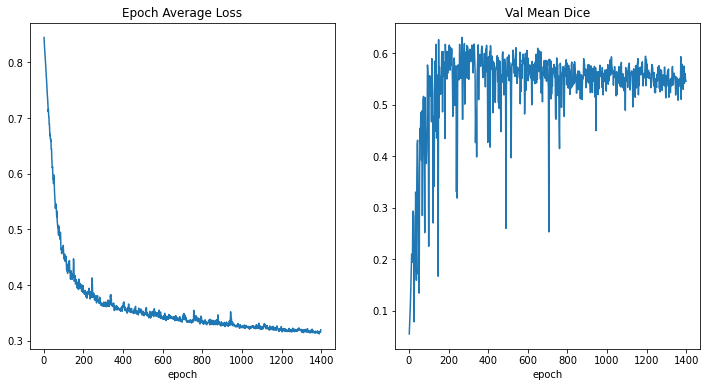

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/Image_262499828648_clean.mha


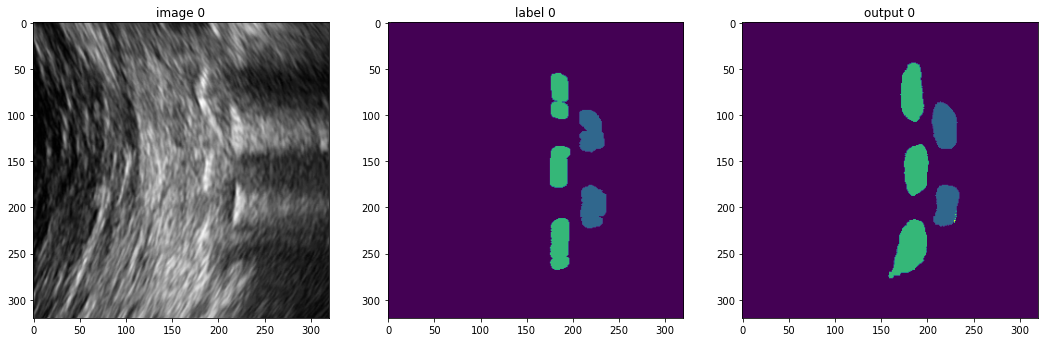

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_1895283541879_clean.mha


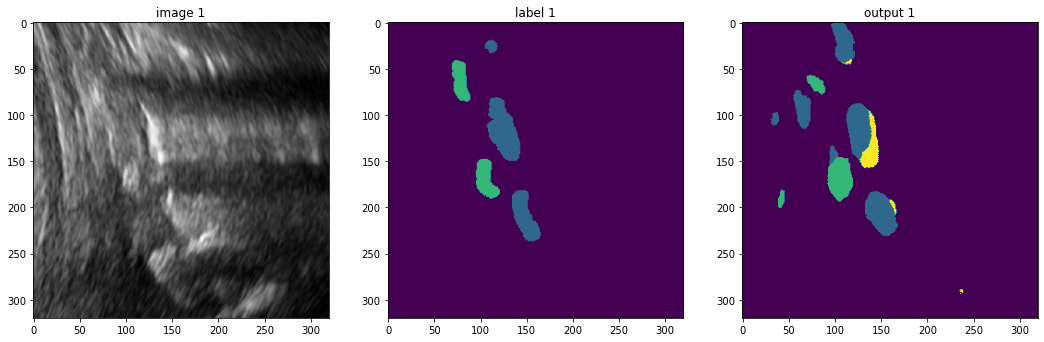

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_4641643404894_CLEAN.mha


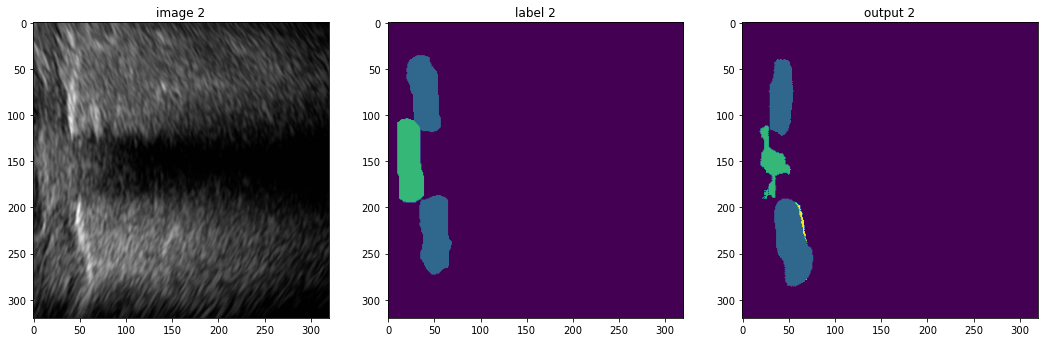

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_614587120545_clean.mha


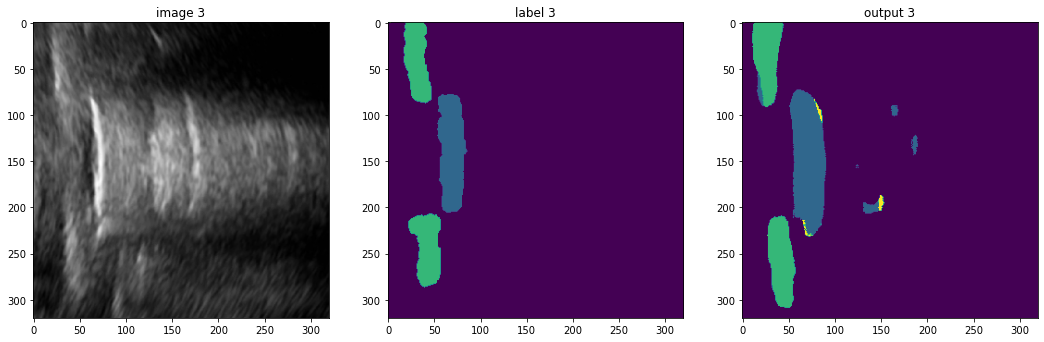

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_104932526155699_CLEAN.mha


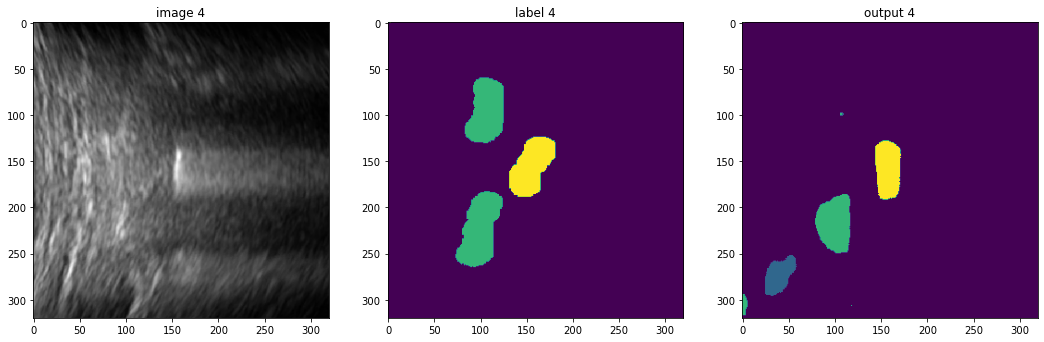

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_1327616672148_clean.mha


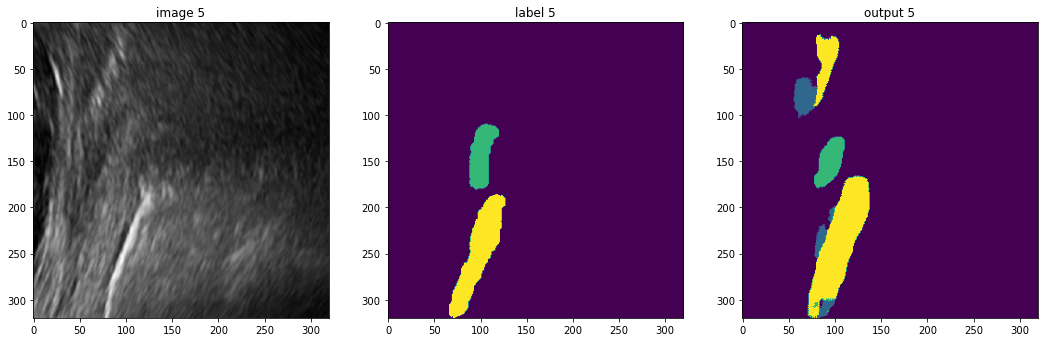

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_3315947589826_clean.mha


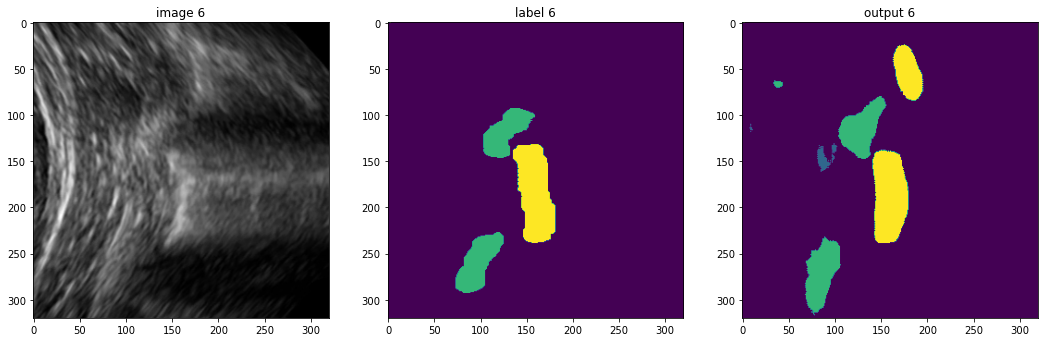

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_73815992352100_clean.mha


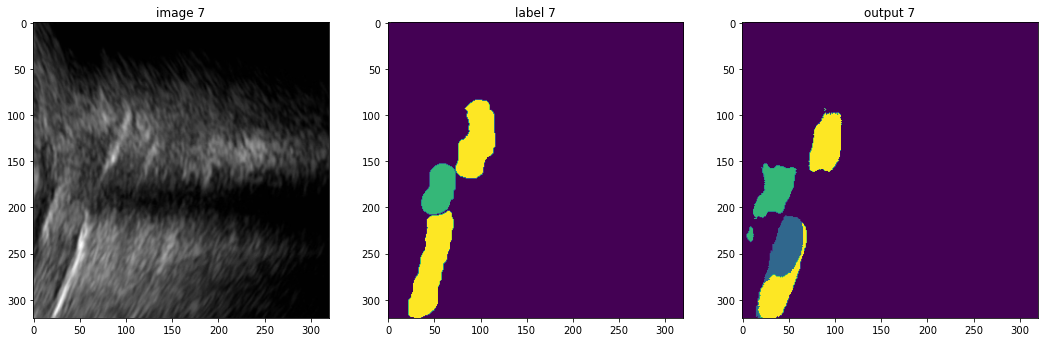

In [19]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "BAMC_PTX_3DUNet-4Class.best_model.pth")))
model.eval()
with torch.no_grad():
    i = 0
    for b,val_data in enumerate(val_loader):
        roi_size = (320, 320, 48)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        for j in range(val_outputs.shape[0]):
            print(val_images[i])
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            tmpV = val_data["image"][j, 0, :, :, 10]
            plt.imshow(tmpV, cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            tmpV = val_data["label"][j, 0, :, :, 10]
            tmpV[0,0]=1
            tmpV[0,1]=2
            tmpV[0,2]=3
            plt.imshow(tmpV)
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            tmpV = torch.argmax(val_outputs, dim=1).detach().cpu()[j, :, :, 10]
            tmpV[0,0]=1
            tmpV[0,1]=2
            tmpV[0,2]=3
            plt.imshow(tmpV)
            plt.show()
            i += 1

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=0)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=True, num_classes=4),
    AsDiscreted(keys="label", to_onehot=True, num_classes=4),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "BAMC_PTX_3DUNet-4Class.best_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (320, 320, 48)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)